In [2]:
import torch
import numpy as np
import pandas as pd
import pickle as pk
from tqdm import tqdm
import torch.nn.functional as F # pytorch 激活函数的类
from torch import nn,optim # 构建模型和优化器
from operator import itemgetter
from collections import defaultdict

# 构建分类模型
class TextRNN(nn.Module):
    def __init__(self, parameter):
        super(TextRNN, self).__init__()
        embedding_dim = parameter['embedding_dim']
        hidden_size = parameter['hidden_size']
        output_size = parameter['output_size']
        num_layers = parameter['num_layers']
        dropout = parameter['dropout']
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*2, output_size)
        
    def forward(self, x):
        out,(h, c)= self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    

class TextCNN(nn.Module):
    def __init__(self, parameter):
        super(TextCNN, self).__init__()
        filter_size=(3,4,5)
        hidden_size = parameter['hidden_size']
        embedding_dim = parameter['embedding_dim']
        output_size = parameter['output_size']
        dropout = parameter['dropout']
        
        self.convs = nn.ModuleList([nn.Conv2d(1, hidden_size,(k, embedding_dim)) for k in filter_size])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * len(filter_size), output_size)

    def forward(self, x):
        x = x.unsqueeze(1) # [batch, channel, word_num, embedding_dim] = [N,C,H,W] -> (163, 1, 20, 300)
        x = [F.tanh(conv(x)).squeeze(3) for conv in self.convs] # len(filter_size) * (N, filter_num, H) -> 3 * (163, 100, 18)
        out_new = []
        for output in x:
            try:
                out_new.append(F.max_pool1d(output,output.shape[2].item()).squeeze(2))
            except:
                out_new.append(F.max_pool1d(output,output.shape[2]).squeeze(2))
        x = out_new
        x = torch.cat(x, 1) # (N, filter_num * len(filter_size)) -> (163, 100 * 3)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    

class TextRCNN(nn.Module):
    def __init__(self, parameter):
        super(TextRCNN, self).__init__()
        embedding_dim = parameter['embedding_dim']
        hidden_size = parameter['hidden_size']
        output_size = parameter['output_size']
        num_layers = parameter['num_layers']
        dropout = parameter['dropout']
        self.lstm = nn.LSTM(embedding_dim,hidden_size, \
                            num_layers, bidirectional=True, \
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.fc_for_concat = nn.Linear(hidden_size * 2 + embedding_dim, hidden_size * 2)
    
    def forward(self, x):
        out,(h, c)= self.lstm(x)
        out = self.fc_for_concat(torch.cat((x, out), 2))
        # 激活函数
        out = F.tanh(out)
        out = out.permute(0, 2, 1)
        try:
            out = F.max_pool1d(out, out.size(2).item())
        except:
            out = F.max_pool1d(out, out.size(2))
        out = out.squeeze(-1)
        out = self.dropout(out)
        out = self.fc(out)
        return out
    
class TextRNN_Attention(nn.Module):
    def __init__(self, parameter):
        super(TextRNN_Attention, self).__init__()
        embedding_dim = parameter['embedding_dim']
        hidden_size = parameter['hidden_size']
        output_size = parameter['output_size']
        num_layers = parameter['num_layers']
        dropout = parameter['dropout']
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc_attention = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, output_size)
        # attention
        self.w = nn.Parameter(torch.zeros(hidden_size * 2))
        
    def forward(self, x):
        out,(h, c)= self.lstm(x)
        alpha = F.softmax(torch.matmul(F.tanh(self.fc_attention(out)),self.w),dim = 1).unsqueeze(-1)
        out = F.relu(torch.sum(out * alpha,1))
        out = self.fc(out)
        return out
    
def batch_yield(chars,labels,parameter,shuffle = True):
    for train_epoch in range(parameter['epoch']):
        if shuffle:
            permutation = np.random.permutation(len(chars))
            chars = chars[permutation]
            labels = labels[permutation]
        max_len = 0
        batch_x,batch_y,x_len = [],[],[]
        for iters in tqdm(range(len(chars))):
            batch_ids = itemgetter(*chars[iters])(parameter['char2ind'])
            try:
                batch_ids = list(batch_ids)
            except:
                batch_ids = [batch_ids,0]
            if len(batch_ids) > max_len:
                max_len = len(batch_ids)
            batch_x.append(batch_ids)
            batch_y.append(labels[iters])
            x_len.append(len(batch_ids))
            if len(batch_x) >= parameter['batch_size']:
                batch_x = [np.array(list(itemgetter(*x_ids)(parameter['ind2embeding']))+[parameter['ind2embeding'][0]]*(max_len-len(x_ids))) for x_ids in batch_x]
                device = parameter['cuda']
                yield torch.from_numpy(np.array(batch_x)).to(device),np.array(batch_y),x_len,True,None
                max_len,batch_x,batch_y,x_len = 0,[],[],[]
        batch_x = [np.array(list(itemgetter(*x_ids)(parameter['ind2embeding']))+[parameter['ind2embeding'][0]]*(max_len-len(x_ids))) for x_ids in batch_x]
        device = parameter['cuda']
        yield torch.from_numpy(np.array(batch_x)).to(device),np.array(batch_y),x_len,True,train_epoch
        max_len,batch_x,batch_y,x_len = 0,[],[],[]
    yield None,None,None,False,None
    
def load_model(way = 'TextRNN'):
    [train_chars,test_chars,train_labels,test_labels] = pk.load(open('dataSet.pkl','rb'))
    parameter = pk.load(open('parameter.pkl','rb'))
#     parameter['cuda'] = torch.device('cpu')
    parameter['dropout'] = 0
    model = eval(way+"(parameter).to(parameter['cuda'])")
    if way == 'TextRNN':
        model.load_state_dict(torch.load('model-rnn.h5'))
    if way == 'TextCNN':
        model.load_state_dict(torch.load('model-cnn.h5'))
    if way == 'TextRCNN':
        model.load_state_dict(torch.load('model-rcnn.h5'))
    if way == 'transformerEncoder':
        model.load_state_dict(torch.load('model-transformerEncoder.h5'))
    if way == 'TextRNN_Attention':
        model.load_state_dict(torch.load('model-rnn+Attention.h5'))
#     model = eval("transformerEncoder(parameter).to(parameter['cuda'])")
#     model.load_state_dict(torch.load('model-lstm.h5'))
    return parameter,model,[test_chars,test_labels]

def compare(real,predict,histroy,parameter):
    com = real - predict
    for i in range(parameter['output_size']):
        histroy[i]['tp'] += len(np.where((com == 0) & (real == i))[0])
        histroy[i]['all_real'] += len(np.where((real == i))[0])
        histroy[i]['all_predict'] += len(np.where((predict == i))[0])

def toEstimate(way = 'TextRNN'):
    global device
    parameter,model,[test_chars,test_labels] = load_model(way)
    model.eval() 
    device = parameter['cuda']
    parameter['epoch'] = 1
    test_yield = batch_yield(test_chars,test_labels,parameter)
    histroy = dict(zip(range(parameter['output_size']),[{'tp':0,'all_real':0,'all_predict':0} for i in range(parameter['output_size'])]))
    while 1:
        seqs,labels,x_len,keys,epoch = next(test_yield)
        if not keys:
            break
        if way == 'transformerEncoder':
            res = model(seqs,x_len)
        else:
            res = model(seqs)
        predicted_prob,predicted_index = torch.max(F.softmax(res, 1), 1)
        res = predicted_index.cpu().numpy()
        compare(labels,res,histroy,parameter)
    print(histroy)
    tp,all_real,all_predict = [histroy[i]['tp'] for i in histroy],[histroy[i]['all_real'] for i in histroy],\
    [histroy[i]['all_predict'] for i in histroy]
    tp.append(sum(tp))
    all_real.append(sum(all_real))
    all_predict.append(sum(all_predict))
    res = pd.DataFrame(np.array([tp,all_real,all_predict]).transpose())
    res.columns = ['tp','all_real','all_predict']
    res['recall'] = res['tp']/res['all_real']
    res['precision'] = res['tp']/res['all_predict']
    res['f1'] = 2*res['recall']*res['precision']/(res['recall']+res['precision'])
    res.index =['标签'+str(i) for i in range(15)]+['综合']
    return res
    
device = None
toEstimate('TextRNN_Attention')
# toEstimate('TextRCNN')

100%|██████████████████████████████████████████████████████████████████████████| 76529/76529 [00:08<00:00, 9504.53it/s]


{0: {'tp': 936, 'all_real': 1238, 'all_predict': 1153}, 1: {'tp': 4586, 'all_real': 5577, 'all_predict': 5414}, 2: {'tp': 6714, 'all_real': 7920, 'all_predict': 8252}, 3: {'tp': 6767, 'all_real': 7524, 'all_predict': 7491}, 4: {'tp': 4089, 'all_real': 5439, 'all_predict': 5229}, 5: {'tp': 3113, 'all_real': 3543, 'all_predict': 3468}, 6: {'tp': 6388, 'all_real': 7141, 'all_predict': 7157}, 7: {'tp': 4773, 'all_real': 5366, 'all_predict': 5591}, 8: {'tp': 6926, 'all_real': 8291, 'all_predict': 8467}, 9: {'tp': 4204, 'all_real': 4970, 'all_predict': 5083}, 10: {'tp': 3411, 'all_real': 4284, 'all_predict': 4407}, 11: {'tp': 4115, 'all_real': 5293, 'all_predict': 5182}, 12: {'tp': 0, 'all_real': 61, 'all_predict': 0}, 13: {'tp': 3299, 'all_real': 4003, 'all_predict': 3934}, 14: {'tp': 5012, 'all_real': 5879, 'all_predict': 5701}}


,tp,all_real,all_predict,recall,precision,f1
标签0,936,1238,1153,0.756058,0.811795,0.782936
标签1,4586,5577,5414,0.822306,0.847063,0.834501
标签2,6714,7920,8252,0.847727,0.813621,0.830324
标签3,6767,7524,7491,0.899389,0.903351,0.901365
标签4,4089,5439,5229,0.751793,0.781985,0.766592
标签5,3113,3543,3468,0.878634,0.897636,0.888033
标签6,6388,7141,7157,0.894553,0.892553,0.893552
标签7,4773,5366,5591,0.889489,0.853693,0.871224
标签8,6926,8291,8467,0.835364,0.817999,0.826590
标签9,4204,4970,5083,0.845875,0.827071,0.836367


In [9]:
import math
import torch
import numpy as np
import pandas as pd
import pickle as pk
from tqdm import tqdm
import torch.nn.functional as F # pytorch 激活函数的类
from torch import nn,optim # 构建模型和优化器
from operator import itemgetter
from collections import defaultdict

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, parameter):#d_model, dropout=0.1, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=parameter['dropout'])
        d_model = parameter['embedding_dim']
        max_len = parameter['max_len']

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
def get_attn_pad_mask(q_len_list, k_len_list):
    global device
    len_q = max(q_len_list)
    len_k = max(k_len_list)
    batch_size = len(q_len_list)
    pad_attn_mask =  torch.from_numpy(np.array([[False]*i+[True]*(len_k-i) for i in k_len_list])).unsqueeze(1)
    return pad_attn_mask.expand(batch_size, len_q, len_k).byte().to(device)  # [batch_size, len_q, len_k]
    

class ScaledDotProductAttention(nn.Module):
    def __init__(self,parameter):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = parameter['d_k']

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
#         print(scores)
#         print('scores:',scores.shape)
        attn = nn.Softmax(dim=-1)(scores)
#         print(attn)
#         print('attn:',attn.shape)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
#         print('context:',context.shape)
        return context, attn
    
class MultiHeadAttention(nn.Module):
    def __init__(self,parameter):
        super(MultiHeadAttention, self).__init__()
        device = parameter['cuda']
        self.d_q,self.d_k,self.d_v,self.d_model,self.n_heads = parameter['d_q'],parameter['d_k'], \
        parameter['d_v'],parameter['embedding_dim'],parameter['n_heads']
        self.W_Q = nn.Linear(self.d_model, self.d_q * self.n_heads, bias=False)
        self.W_K = nn.Linear(self.d_model, self.d_k * self.n_heads, bias=False)
        self.W_V = nn.Linear(self.d_model, self.d_v * self.n_heads, bias=False)
        self.fc = nn.Linear(self.n_heads * self.d_v, self.d_model, bias=False)
        self.sdp = ScaledDotProductAttention(parameter).to(device)
        self.add_norm = nn.LayerNorm(self.d_model)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
#         print('input-shape',input_Q.shape)
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, self.n_heads, self.d_q).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_q]
        K = self.W_K(input_K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]
#         print('QKV-shape',Q.shape,K.shape,V.shape)
#         print('test:',K.transpose(-1,-2).shape)
#         print('attn-shape0:',attn_mask.shape)
#         print(attn_mask.shape)
        attn_mask_new = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]
#         print('attn-shape1:',attn_mask.shape)
#         print(attn_mask.shape)
        context, attn = self.sdp(Q, K, V, attn_mask_new)
        context = context.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        output = self.add_norm(output + residual)
        return output, attn
    
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self,parameter):
        self.d_ff,self.d_model = parameter['d_ff'],parameter['embedding_dim']
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(self.d_model, self.d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(self.d_ff, self.d_model, bias=False)
        )
        self.add_norm = nn.LayerNorm(self.d_model)
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return self.add_norm(output + residual) # [batch_size, seq_len, d_model]
    
class EncoderLayer(nn.Module):
    def __init__(self,parameter):
        super(EncoderLayer, self).__init__()
        device = parameter['cuda']
        self.enc_self_attn = MultiHeadAttention(parameter).to(device)
        self.pos_ffn = PoswiseFeedForwardNet(parameter).to(device)

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn
    
class Encoder(nn.Module):
    def __init__(self,parameter):
        super(Encoder, self).__init__()
        n_layers = parameter['n_layers']
        self.pos_emb = PositionalEncoding(parameter)
        self.layers = nn.ModuleList([EncoderLayer(parameter) for _ in range(n_layers)])

    def forward(self, enc_inputs,len_inputs):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        '''
        enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(len_inputs, len_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns
    
class transformerEncoder(nn.Module):
    def __init__(self,parameter):
        super(transformerEncoder, self).__init__()
        output_dim = parameter['output_size']
        d_model = parameter['embedding_dim']
        device = parameter['cuda']
        self.encoder = Encoder(parameter).to(device)
        self.fc = nn.Linear(d_model, output_dim)
        
    def forward(self,enc_inputs,len_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs,len_inputs)
#         print(enc_outputs.shape)
#         enc_outputs = enc_outputs.permute(0, 2, 1)
        enc_outputs,_ = torch.max(enc_outputs, 1)
#         print(enc_outputs.shape)
        outputs = self.fc(enc_outputs)
        return outputs

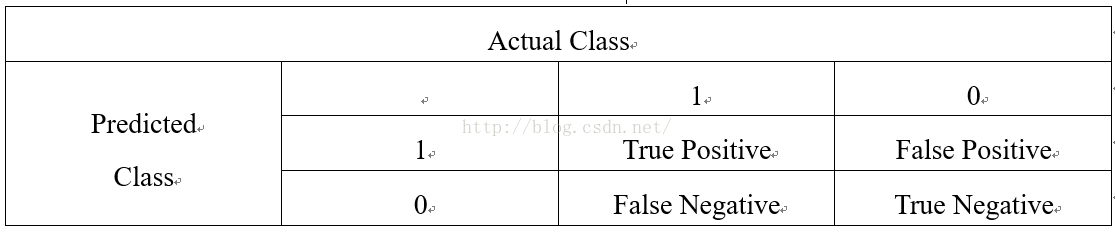

In [ ]:
import torch.nn.functional as F # pytorch 激活函数的类
from torch import nn,optim # 构建模型和优化器
import pickle as pk
import numpy as np
import torch

def batch_yield_predict(chars,parameter):
    batch_x,batch_y = [],[]
    for iters in range(len(chars)):
        if chars[iters] in parameter['char2ind']:
            batch_x.append(parameter['ind2embeding'][parameter['char2ind'][chars[iters]]])
        else:
            batch_x.append(parameter['ind2embeding'][parameter['char2ind']['<unk>']])
    batch_x = [batch_x]
#     batch_y = [0]
    device = parameter['cuda']
    return torch.from_numpy(np.array(batch_x)).to(device)#,torch.from_numpy(np.array(batch_y)).to(device).long()

class TextRCNN(nn.Module):
    def __init__(self, parameter):
        super(TextRCNN, self).__init__()
        embedding_dim = parameter['embedding_dim']
        hidden_size = parameter['hidden_size']
        output_size = parameter['output_size']
        num_layers = parameter['num_layers']
        dropout = parameter['dropout']
        self.lstm = nn.LSTM(embedding_dim,hidden_size, \
                            num_layers, bidirectional=True, \
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2+embedding_dim, output_size)
    
    def forward(self, x):
        out,(h, c)= self.lstm(x)
        out = torch.cat((x, out), 2)
        # 激活函数
        out = F.tanh(out)
        out = out.permute(0, 2, 1)
        try:
            out = F.max_pool1d(out, out.size(2).item())
        except:
            out = F.max_pool1d(out, out.size(2))
        out = out.squeeze(-1)
        out = self.dropout(out)
        out = self.fc(out)
        return out
    
def load_model():
    parameter = pk.load(open('parameter.pkl','rb'))
    model = TextRCNN(parameter).to(parameter['cuda'])
    model.load_state_dict(torch.load('model-rcnn.h5'))
    return parameter,model

def predict(model,parameter,strs):
    strs = strs.split()
    strs = batch_yield_predict(strs,parameter)
    outputs = model(strs)
    predicted_prob,predicted_index = torch.max(F.softmax(outputs, 1), 1)
    return predicted_index.item(),predicted_prob.item()
    

parameter,model = load_model()

test = 'nnt 演 过 那 些 戏'
predict(model,parameter,test)



In [3]:
class TextRNN_Attention(nn.Module):
    def __init__(self, parameter):
        super(TextRNN_Attention, self).__init__()
        embedding_dim = parameter['embedding_dim']
        hidden_size = parameter['hidden_size']
        output_size = parameter['output_size']
        num_layers = parameter['num_layers']
        dropout = parameter['dropout']
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc_attention = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, output_size)
        
        # attention
        self.w = nn.Parameter(torch.zeros(hidden_size * 2))
        
    def forward(self, x):
        out,(h, c)= self.lstm(x)
        
        alpha = F.softmax(torch.matmul(F.tanh(self.fc_attention(out)),self.w),dim = 1).unsqueeze(-1)
        out = F.relu(torch.sum(out * alpha,1))
        out = self.fc(out)
        return out,alpha

In [4]:
way = 'TextRNN_Attention'
[train_chars,test_chars,train_labels,test_labels] = pk.load(open('dataSet.pkl','rb'))
parameter = pk.load(open('parameter.pkl','rb'))
parameter['dropout'] = 0
model = eval(way+"(parameter).to(parameter['cuda'])")
model.load_state_dict(torch.load('model-rnn+Attention.h5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
model.eval() 
device = parameter['cuda']
parameter['epoch'] = 1
test_ins = np.array(['一 元 硬 币 是 这 种 现 在 价 值 num 元 找 找 看'.split(),\
                         '下 联 夕 陽 西 下 已 黄 昏 上 联 是 什 麽'.split(),\
                    '十 万 元 能 上 路 的 汽 车 买 什 么 比 较 好'.split(),\
                    '特 朗 普 为 支 持 拥 枪 拿 伦 敦 当 反 面 教 材'.split()]),np.array([1,1,6,11])
test_yield = batch_yield(*test_ins,parameter,shuffle = False)
seqs,labels,x_len,keys,epoch = next(test_yield)
out,alpha = model(seqs)
torch.max(F.softmax(out, 1), 1),np.around(F.softmax(out, 1).cpu().detach().numpy(),3)

D:\Anaconda3-5.3\envs\nlp\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(torch.return_types.max(
 values=tensor([0.8059, 0.9979, 0.9928, 0.9914], device='cuda:0',
        grad_fn=<MaxBackward0>),
 indices=tensor([ 1,  1,  6, 11], device='cuda:0')),
 array([[0.   , 0.806, 0.   , 0.001, 0.176, 0.001, 0.   , 0.   , 0.002,
         0.001, 0.   , 0.007, 0.001, 0.001, 0.003],
        [0.   , 0.998, 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.993, 0.   , 0.004,
         0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.001, 0.002, 0.002, 0.   , 0.   , 0.   , 0.   ,
         0.004, 0.   , 0.991, 0.   , 0.   , 0.   ]], dtype=float32))

In [66]:
seqs

tensor([[[-3.2381e+00,  1.2783e-01, -1.4556e+00,  ...,  2.5821e+00,
           4.7758e+00, -3.7567e-01],
         [ 4.6198e-01, -7.2332e-01,  3.2733e+00,  ..., -1.8295e+00,
           1.4050e+00, -5.9407e+00],
         [ 3.0078e+00,  4.3929e-01, -8.5224e-01,  ...,  4.5261e-01,
          -2.8140e+00, -1.2985e+00],
         ...,
         [-1.4830e+00, -7.9927e-01, -1.0464e+00,  ...,  1.4740e+00,
           1.0086e+00, -6.1044e-02],
         [-1.4830e+00, -7.9927e-01, -1.0464e+00,  ...,  1.4740e+00,
           1.0086e+00, -6.1044e-02],
         [-1.5632e-01,  8.3224e-01, -2.1072e+00,  ...,  8.6913e-01,
           2.6341e+00,  3.1374e+00]],

        [[ 1.7158e-01, -4.2617e-01, -4.8433e-01,  ..., -4.3868e-01,
           2.1605e+00,  5.1938e-01],
         [ 1.1475e+00, -3.1508e+00,  6.4085e+00,  ...,  6.7769e-01,
           2.4792e+00,  3.3659e+00],
         [ 1.0284e+00,  5.8255e+00, -1.5697e+00,  ..., -1.1450e-01,
           8.7394e-02, -3.1986e+00],
         ...,
         [ 7.0657e-03,  2

['十', '万', '元', '能', '上', '路', '的', '汽', '车', '买', '什', '么', '比', '较', '好', 'pad']


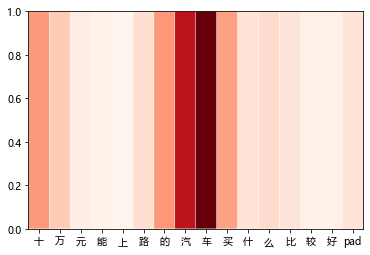

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

ins_num = 2
y_label = test_ins[0][ins_num]
attention = alpha[ins_num,:,0].cpu().detach().numpy()
target = [attention]
y_label += ['pad']*(len(attention) - len(y_label))
print(y_label)
plt.pcolor(target, cmap=plt.cm.Reds, edgecolors = 'white')
# 添加x轴和y轴刻度标签(加0.5是为了让刻度标签居中显示)
a = plt.xticks(np.arange(len(attention))+0.5,y_label)